In [1]:
import torch
import pandas as pd
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
import copy
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

Using device: cuda


In [2]:
mnist_df = pd.read_csv('mnist_train.csv')
mnist_df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_test_df = pd.read_csv('mnist_test.csv')
mnist_test_df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train a base model on the whole dataset

In [4]:
mnist_X = mnist_df.drop(columns=["label"]).values
mnist_y = mnist_df['label'].values

In [5]:
mnist_test_X = mnist_test_df.drop(columns=["label"]).values
mnist_test_y = mnist_test_df['label'].values

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx].reshape(28, 28) / 255.0
        img = img.unsqueeze(0)
        img = img.repeat(3, 1, 1)

        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        label = self.y[idx]
        return img, label
    

train_dataset = MNISTDataset(mnist_X, mnist_y)
test_dataset = MNISTDataset(mnist_test_X, mnist_test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
base_model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

In [8]:
base_model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

In [10]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

base_loss_list = []
base_accuracy_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    base_model.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = base_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    base_loss_list.append(avg_train_loss)


    base_model.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = base_model(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    base_accuracy_list.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(base_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.0684, Val Loss: 0.0469, Val Accuracy: 0.9849
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0306, Val Loss: 0.0673, Val Accuracy: 0.9803
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0238, Val Loss: 0.0452, Val Accuracy: 0.9858
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0232, Val Loss: 0.0308, Val Accuracy: 0.9903
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0208, Val Loss: 0.0540, Val Accuracy: 0.9863
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0184, Val Loss: 0.0220, Val Accuracy: 0.9937
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0167, Val Loss: 0.0277, Val Accuracy: 0.9923
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0146, Val Loss: 0.0246, Val Accuracy: 0.9928
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0153, Val Loss: 0.0226, Val Accuracy: 0.9942
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0117, Val Loss: 0.0235, Val Accuracy: 0.9935
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0136, Val Loss: 0.0340, Val Accuracy: 0.9898
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0122, V

In [11]:
with torch.no_grad():
    base_model.load_state_dict(best_model_weights)
    base_model.eval()
    base_model.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = base_model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(mnist_test_y, y_pred)
conf_matrix = confusion_matrix(mnist_test_y, y_pred)
class_report = classification_report(mnist_test_y, y_pred)

Accuracy of base model = 0.9937


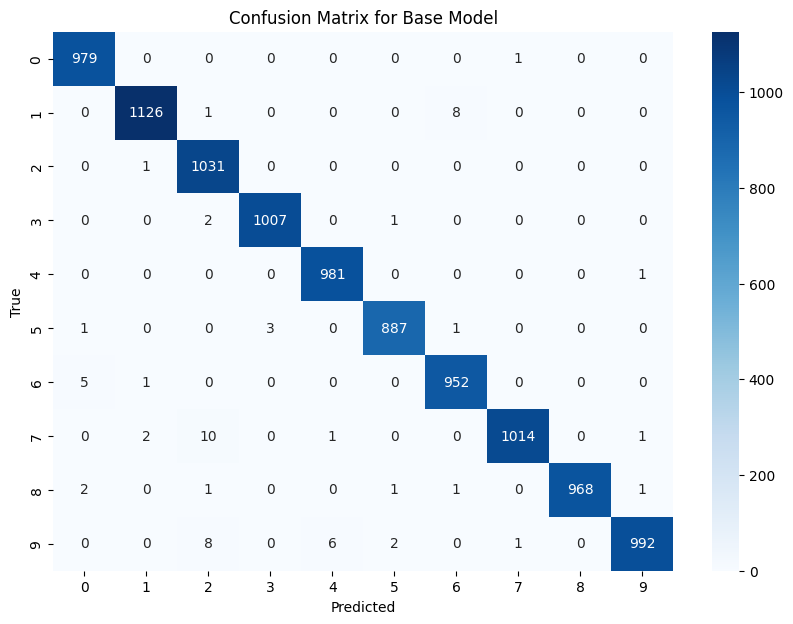

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [12]:
print(f"Accuracy of base model = {accuracy}")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Base Model')
plt.show()
print(class_report)

Dividing training data into 10% labelled and 90% unlabelled

In [13]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for _, subset_idx in strat_split.split(mnist_X, mnist_y):
    labeled_X = mnist_X[subset_idx]
    y = mnist_y[subset_idx]
    unlabeled_X = mnist_X[_]

In [14]:
strat_split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test, train in strat_split1.split(labeled_X, y):
    X_train = labeled_X[train]
    y_train = y[train]
    X_val = labeled_X[test]
    y_val = y[test]

In [15]:
labeled_train_dataset = MNISTDataset(labeled_X, y)
train_loader = DataLoader(labeled_train_dataset, batch_size=64, shuffle=True)

val_dataset = MNISTDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

unlabeled_dataset = MNISTDataset(unlabeled_X, np.zeros(len(unlabeled_X)))
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

In [16]:
model1 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

model1.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [17]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list_10 = []
accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    loss_list_10.append(avg_train_loss)


    model1.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   
model1.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.2567, Val Loss: 0.6965, Val Accuracy: 0.7855
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0448, Val Loss: 0.2154, Val Accuracy: 0.9350
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0413, Val Loss: 0.0833, Val Accuracy: 0.9736
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0237, Val Loss: 0.1367, Val Accuracy: 0.9606
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0348, Val Loss: 0.0559, Val Accuracy: 0.9813
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0146, Val Loss: 0.2114, Val Accuracy: 0.9333
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0087, Val Loss: 0.0693, Val Accuracy: 0.9818
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0117, Val Loss: 0.0435, Val Accuracy: 0.9888
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0091, Val Loss: 0.0766, Val Accuracy: 0.9752
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0176, Val Loss: 0.0683, Val Accuracy: 0.9830
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0169, Val Loss: 0.0715, Val Accuracy: 0.9834
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0122, V

<All keys matched successfully>

In [18]:
pseudo_indices_07 = []
pseudo_labels_07 = []

start_idx = 0

with torch.no_grad():
    model1.load_state_dict(best_model_weights)
    model1.eval()
    model1.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model1(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_07.append(batch_indices[mask_07.cpu()])
        pseudo_labels_07.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_07 = torch.cat(pseudo_indices_07)
pseudo_labels_07 = torch.cat(pseudo_labels_07)


In [19]:
pseudo_indices_08 = []
pseudo_labels_08 = []

start_idx = 0

with torch.no_grad():
    model1.load_state_dict(best_model_weights)
    model1.eval()
    model1.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model1(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.8

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_08.append(batch_indices[mask_07.cpu()])
        pseudo_labels_08.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_08 = torch.cat(pseudo_indices_08)
pseudo_labels_08 = torch.cat(pseudo_labels_08)


In [20]:
pseudo_indices_09 = []
pseudo_labels_09 = []

start_idx = 0

with torch.no_grad():
    model1.load_state_dict(best_model_weights)
    model1.eval()
    model1.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model1(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.9

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_09.append(batch_indices[mask_07.cpu()])
        pseudo_labels_09.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_09 = torch.cat(pseudo_indices_09)
pseudo_labels_09 = torch.cat(pseudo_labels_09)


In [ ]:
# class PseudoDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y
    
#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, idx):
#         img = self.X[idx].reshape(28, 28).astype("float32") / 255.0
#         img = torch.tensor(img).unsqueeze(0)
#         img = img.repeat(3, 1, 1)

#         img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

#         label = torch.tensor(self.y[idx], dtype=torch.long)
#         return img, label
    
# combined_dataset_07 = ConcatDataset([PseudoDataset(pseudo_images_07, pseudo_labels_07), labeled_train_dataset])
# combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

# combined_dataset_08 = ConcatDataset([PseudoDataset(pseudo_images_08, pseudo_labels_08), labeled_train_dataset])
# combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

# combined_dataset_09 = ConcatDataset([PseudoDataset(pseudo_images_09, pseudo_labels_09), labeled_train_dataset])
# combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [21]:
class PseudoDataset(Dataset):
    def __init__(self, base_dataset, indices, pseudo_labels):
        self.base_dataset = base_dataset
        self.indices = indices
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img, _ = self.base_dataset[self.indices[idx]]
        label = self.pseudo_labels[idx]
        return img, label
    
pseudo_dataset_07 = PseudoDataset(unlabeled_dataset, pseudo_indices_07, pseudo_labels_07)
combined_dataset_07 = ConcatDataset([labeled_train_dataset, pseudo_dataset_07])
combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

pseudo_dataset_08 = PseudoDataset(unlabeled_dataset, pseudo_indices_08, pseudo_labels_08)
combined_dataset_08 = ConcatDataset([labeled_train_dataset, pseudo_dataset_08])
combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

pseudo_dataset_09 = PseudoDataset(unlabeled_dataset, pseudo_indices_09, pseudo_labels_09)

combined_dataset_09 = ConcatDataset([labeled_train_dataset, pseudo_dataset_09])
combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [22]:
model1_07 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1_07.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model1_07.to(device)
loss_fn_07 = torch.nn.CrossEntropyLoss()
optimizer_07 = torch.optim.Adam(model1_07.parameters(), lr=0.001)

model1_08 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1_08.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model1_08.to(device)
loss_fn_08 = torch.nn.CrossEntropyLoss()
optimizer_08 = torch.optim.Adam(model1_08.parameters(), lr=0.001)

model1_09 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1_09.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model1_09.to(device)
loss_fn_09 = torch.nn.CrossEntropyLoss()
optimizer_09 = torch.optim.Adam(model1_09.parameters(), lr=0.001)


In [23]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1_07.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_07:
        optimizer_07.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1_07(X_batch)
        loss = loss_fn_07(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_07.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model1_07.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1_07(X_batch)
            test_loss = loss_fn_07(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1_07.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model1_07.load_state_dict(best_model_weights)


Epoch 1/1000
Epoch 1/1000, Train Loss: 0.7070, Val Loss: 0.0353, Val Accuracy: 0.9886
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.3264, Val Loss: 0.0517, Val Accuracy: 0.9852
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.2902, Val Loss: 0.0496, Val Accuracy: 0.9860
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.2500, Val Loss: 0.0401, Val Accuracy: 0.9877
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.2337, Val Loss: 0.0638, Val Accuracy: 0.9857
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.2070, Val Loss: 0.0524, Val Accuracy: 0.9878
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.1873, Val Loss: 0.0379, Val Accuracy: 0.9893
Epoch 8/1000
Early stopping at epoch 8


<All keys matched successfully>

In [24]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1_08.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_08:
        optimizer_08.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1_08(X_batch)
        loss = loss_fn_08(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_08.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model1_08.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1_08(X_batch)
            test_loss = loss_fn_08(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1_08.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model1_08.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.6548, Val Loss: 0.0704, Val Accuracy: 0.9773
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.3000, Val Loss: 0.0771, Val Accuracy: 0.9782
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.2674, Val Loss: 0.0406, Val Accuracy: 0.9887
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.2185, Val Loss: 0.0539, Val Accuracy: 0.9852
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.2147, Val Loss: 0.0702, Val Accuracy: 0.9819
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.1863, Val Loss: 0.0466, Val Accuracy: 0.9881
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.1764, Val Loss: 0.0431, Val Accuracy: 0.9896
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.1668, Val Loss: 0.0473, Val Accuracy: 0.9876
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.1381, Val Loss: 0.0509, Val Accuracy: 0.9873
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.1344, Val Loss: 0.0323, Val Accuracy: 0.9909
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.1226, Val Loss: 0.0486, Val Accuracy: 0.9887
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.1153, V

<All keys matched successfully>

In [25]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1_09.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_09:
        optimizer_09.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1_09(X_batch)
        loss = loss_fn_09(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_09.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model1_09.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1_09(X_batch)
            test_loss = loss_fn_09(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1_09.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model1_09.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.5798, Val Loss: 0.0716, Val Accuracy: 0.9795
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.2656, Val Loss: 0.0385, Val Accuracy: 0.9873
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.2360, Val Loss: 0.0588, Val Accuracy: 0.9847
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.1773, Val Loss: 0.0421, Val Accuracy: 0.9892
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.1663, Val Loss: 0.1155, Val Accuracy: 0.9729
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.1661, Val Loss: 0.0418, Val Accuracy: 0.9883
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.1617, Val Loss: 0.0526, Val Accuracy: 0.9860
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.1404, Val Loss: 0.0403, Val Accuracy: 0.9897
Epoch 9/1000
Early stopping at epoch 9


<All keys matched successfully>

In [26]:
all_preds_07 = []
all_preds_08 = []
all_preds_09 = []

with torch.no_grad():
    model1_07.eval()
    model1_07.to(device)
    model1_08.eval()
    model1_08.to(device)
    model1_09.eval()
    model1_09.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs_07 = model1_07(X_batch)
        outputs_08 = model1_08(X_batch)
        outputs_09 = model1_09(X_batch)

        preds_07 = torch.argmax(outputs_07, dim=1)
        preds_08 = torch.argmax(outputs_08, dim=1)
        preds_09 = torch.argmax(outputs_09, dim=1)

        all_preds_07.append(preds_07.cpu())
        all_preds_08.append(preds_08.cpu())
        all_preds_09.append(preds_09.cpu())

all_preds_07 = torch.cat(all_preds_07)
all_preds_08 = torch.cat(all_preds_08)
all_preds_09 = torch.cat(all_preds_09)

accuracy_07 = accuracy_score(mnist_test_y, all_preds_07)
conf_matrix_07 = confusion_matrix(mnist_test_y, all_preds_07)
class_report_07 = classification_report(mnist_test_y, all_preds_07)

accuracy_08 = accuracy_score(mnist_test_y, all_preds_08)
conf_matrix_08 = confusion_matrix(mnist_test_y, all_preds_08)
class_report_08 = classification_report(mnist_test_y, all_preds_08)

accuracy_09 = accuracy_score(mnist_test_y, all_preds_09)
conf_matrix_09 = confusion_matrix(mnist_test_y, all_preds_09)
class_report_09 = classification_report(mnist_test_y, all_preds_09)

Accuracy of model trained with 10% labeled data and pseudo-labeling:
0.7 Confidence Threshold: 0.9885
0.8 Confidence Threshold: 0.9909
0.9 Confidence Threshold: 0.9872


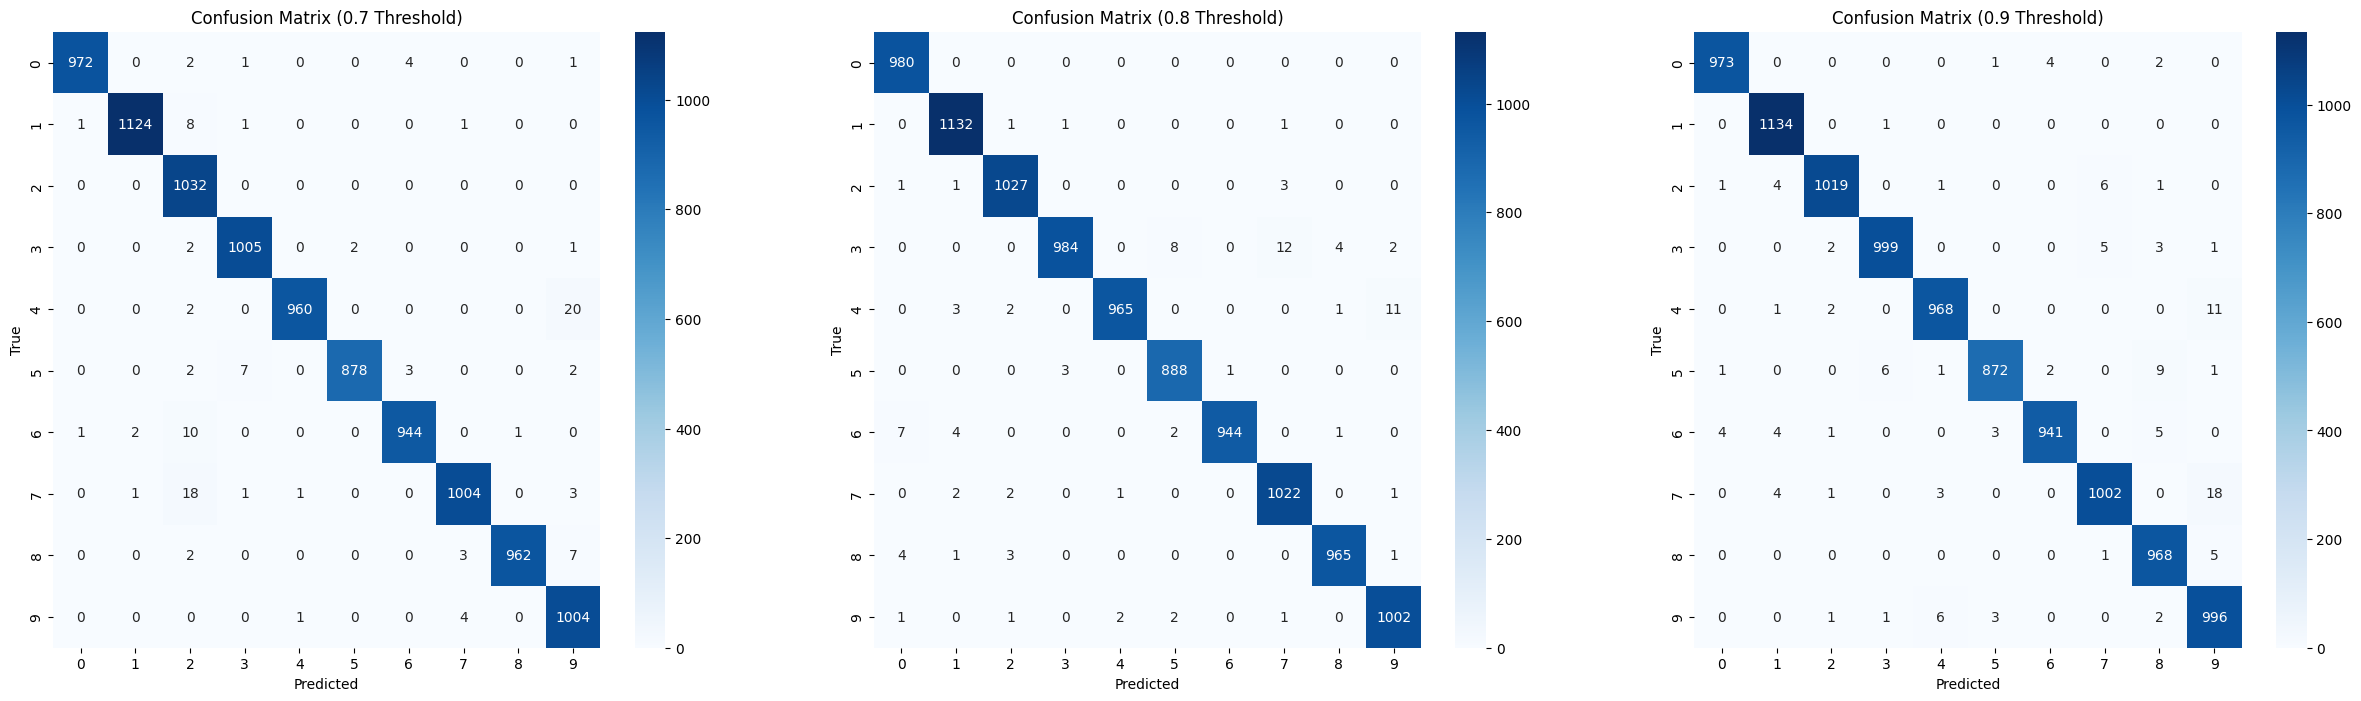

Classification Report (0.7 Threshold):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.96      1.00      0.98      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       1.00      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       1.00      0.99      0.99       974
           9       0.97      1.00      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Classification Report (0.8 Threshold):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135

In [27]:
print(f"Accuracy of model trained with 10% labeled data and pseudo-labeling:")
print(f"0.7 Confidence Threshold: {accuracy_07}")
print(f"0.8 Confidence Threshold: {accuracy_08}")
print(f"0.9 Confidence Threshold: {accuracy_09}")

plt.figure(figsize=(30, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        sns.heatmap(conf_matrix_07, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.7 Threshold)')
    elif i == 1:
        sns.heatmap(conf_matrix_08, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.8 Threshold)')
    else:
        sns.heatmap(conf_matrix_09, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.9 Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.show()

print("Classification Report (0.7 Threshold):")
print(class_report_07)
print("\nClassification Report (0.8 Threshold):")
print(class_report_08)
print("\nClassification Report (0.9 Threshold):")
print(class_report_09)

Training a model on 20% labeled and 80% unlabeled data

In [28]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for _, subset_idx in strat_split.split(mnist_X, mnist_y):
    labeled_X = mnist_X[subset_idx]
    y = mnist_y[subset_idx]
    unlabeled_X = mnist_X[_]

In [29]:
strat_split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test, train in strat_split1.split(labeled_X, y):
    X_train = labeled_X[train]
    y_train = y[train]
    X_val = labeled_X[test]
    y_val = y[test]

In [30]:
labeled_train_dataset = MNISTDataset(labeled_X, y)
train_loader = DataLoader(labeled_train_dataset, batch_size=64, shuffle=True)

val_dataset = MNISTDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

unlabeled_dataset = MNISTDataset(unlabeled_X, np.zeros(len(unlabeled_X)))
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

In [31]:
model2 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

model2.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [32]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list_10 = []
accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    loss_list_10.append(avg_train_loss)


    model2.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2.load_state_dict(best_model_weights) 

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.1563, Val Loss: 0.3635, Val Accuracy: 0.8937
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0447, Val Loss: 0.0551, Val Accuracy: 0.9815
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0297, Val Loss: 0.0949, Val Accuracy: 0.9712
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0272, Val Loss: 0.0979, Val Accuracy: 0.9742
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0202, Val Loss: 0.0419, Val Accuracy: 0.9878
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0185, Val Loss: 0.1836, Val Accuracy: 0.9543
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0313, Val Loss: 0.0395, Val Accuracy: 0.9896
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0079, Val Loss: 0.0342, Val Accuracy: 0.9916
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0159, Val Loss: 0.0286, Val Accuracy: 0.9920
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0077, Val Loss: 0.0451, Val Accuracy: 0.9882
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0099, Val Loss: 0.0906, Val Accuracy: 0.9808
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0256, V

<All keys matched successfully>

In [36]:
pseudo_indices_07 = []
pseudo_labels_07 = []

start_idx = 0

with torch.no_grad():
    model2.load_state_dict(best_model_weights)
    model2.eval()
    model2.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model2(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_07.append(batch_indices[mask_07.cpu()])
        pseudo_labels_07.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_07 = torch.cat(pseudo_indices_07)
pseudo_labels_07 = torch.cat(pseudo_labels_07)


In [37]:
pseudo_indices_08 = []
pseudo_labels_08 = []

start_idx = 0

with torch.no_grad():
    model2.load_state_dict(best_model_weights)
    model2.eval()
    model2.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model2(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.8

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_08.append(batch_indices[mask_07.cpu()])
        pseudo_labels_08.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_08 = torch.cat(pseudo_indices_08)
pseudo_labels_08 = torch.cat(pseudo_labels_08)


In [38]:
pseudo_indices_09 = []
pseudo_labels_09 = []

start_idx = 0

with torch.no_grad():
    model2.load_state_dict(best_model_weights)
    model2.eval()
    model2.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model2(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.9

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_09.append(batch_indices[mask_07.cpu()])
        pseudo_labels_09.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_09 = torch.cat(pseudo_indices_09)
pseudo_labels_09 = torch.cat(pseudo_labels_09)


In [39]:
class PseudoDataset(Dataset):
    def __init__(self, base_dataset, indices, pseudo_labels):
        self.base_dataset = base_dataset
        self.indices = indices
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img, _ = self.base_dataset[self.indices[idx]]
        label = self.pseudo_labels[idx]
        return img, label
    
pseudo_dataset_07 = PseudoDataset(unlabeled_dataset, pseudo_indices_07, pseudo_labels_07)
combined_dataset_07 = ConcatDataset([labeled_train_dataset, pseudo_dataset_07])
combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

pseudo_dataset_08 = PseudoDataset(unlabeled_dataset, pseudo_indices_08, pseudo_labels_08)
combined_dataset_08 = ConcatDataset([labeled_train_dataset, pseudo_dataset_08])
combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

pseudo_dataset_09 = PseudoDataset(unlabeled_dataset, pseudo_indices_09, pseudo_labels_09)

combined_dataset_09 = ConcatDataset([labeled_train_dataset, pseudo_dataset_09])
combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [40]:
model2_07 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2_07.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model2_07.to(device)
loss_fn_07 = torch.nn.CrossEntropyLoss()
optimizer_07 = torch.optim.Adam(model2_07.parameters(), lr=0.001)

model2_08 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2_08.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model2_08.to(device)
loss_fn_08 = torch.nn.CrossEntropyLoss()
optimizer_08 = torch.optim.Adam(model2_08.parameters(), lr=0.001)

model2_09 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2_09.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model2_09.to(device)
loss_fn_09 = torch.nn.CrossEntropyLoss()
optimizer_09 = torch.optim.Adam(model2_09.parameters(), lr=0.001)


In [41]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2_07.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_07:
        optimizer_07.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2_07(X_batch)
        loss = loss_fn_07(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_07.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model2_07.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2_07(X_batch)
            test_loss = loss_fn_07(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2_07.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2_07.load_state_dict(best_model_weights)


Epoch 1/1000
Epoch 1/1000, Train Loss: 0.3351, Val Loss: 0.0502, Val Accuracy: 0.9865
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.1492, Val Loss: 0.0482, Val Accuracy: 0.9851
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.1324, Val Loss: 0.0439, Val Accuracy: 0.9870
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.1188, Val Loss: 0.0368, Val Accuracy: 0.9895
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.1035, Val Loss: 0.0535, Val Accuracy: 0.9853
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0951, Val Loss: 0.0318, Val Accuracy: 0.9909
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0891, Val Loss: 0.0376, Val Accuracy: 0.9892
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0742, Val Loss: 0.0504, Val Accuracy: 0.9875
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0823, Val Loss: 0.0450, Val Accuracy: 0.9875
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0648, Val Loss: 0.0363, Val Accuracy: 0.9910
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0654, Val Loss: 0.0538, Val Accuracy: 0.9867
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0660, V

<All keys matched successfully>

In [42]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2_08.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_08:
        optimizer_08.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2_08(X_batch)
        loss = loss_fn_08(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_08.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model2_08.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2_08(X_batch)
            test_loss = loss_fn_08(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2_08.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2_08.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.3200, Val Loss: 0.0355, Val Accuracy: 0.9876
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.1437, Val Loss: 0.0391, Val Accuracy: 0.9888
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.1188, Val Loss: 0.0438, Val Accuracy: 0.9869
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.1087, Val Loss: 0.0711, Val Accuracy: 0.9812
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.1003, Val Loss: 0.0431, Val Accuracy: 0.9879
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0874, Val Loss: 0.0488, Val Accuracy: 0.9875
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0739, Val Loss: 0.0398, Val Accuracy: 0.9896
Epoch 8/1000
Early stopping at epoch 8


<All keys matched successfully>

In [43]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2_09.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_09:
        optimizer_09.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2_09(X_batch)
        loss = loss_fn_09(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_09.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model2_09.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2_09(X_batch)
            test_loss = loss_fn_09(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2_09.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2_09.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.3033, Val Loss: 0.0678, Val Accuracy: 0.9784
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.1278, Val Loss: 0.0526, Val Accuracy: 0.9860
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0940, Val Loss: 0.0387, Val Accuracy: 0.9885
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.1040, Val Loss: 0.0309, Val Accuracy: 0.9909
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0783, Val Loss: 0.0331, Val Accuracy: 0.9901
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0843, Val Loss: 0.0368, Val Accuracy: 0.9913
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0670, Val Loss: 0.0532, Val Accuracy: 0.9879
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0688, Val Loss: 0.0515, Val Accuracy: 0.9881
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0607, Val Loss: 0.0484, Val Accuracy: 0.9895
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0573, Val Loss: 0.0510, Val Accuracy: 0.9880
Epoch 11/1000
Early stopping at epoch 11


<All keys matched successfully>

In [44]:
all_preds_07 = []
all_preds_08 = []
all_preds_09 = []


with torch.no_grad():
    model2_07.eval()
    model2_07.to(device)
    model2_08.eval()
    model2_08.to(device)
    model2_09.eval()
    model2_09.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs_07 = model2_07(X_batch)
        outputs_08 = model2_08(X_batch)
        outputs_09 = model2_09(X_batch)

        preds_07 = torch.argmax(outputs_07, dim=1)
        preds_08 = torch.argmax(outputs_08, dim=1)
        preds_09 = torch.argmax(outputs_09, dim=1)

        all_preds_07.append(preds_07.cpu())
        all_preds_08.append(preds_08.cpu())
        all_preds_09.append(preds_09.cpu())

all_preds_07 = torch.cat(all_preds_07)
all_preds_08 = torch.cat(all_preds_08)
all_preds_09 = torch.cat(all_preds_09)


accuracy_07 = accuracy_score(mnist_test_y, all_preds_07)
conf_matrix_07 = confusion_matrix(mnist_test_y, all_preds_07)
class_report_07 = classification_report(mnist_test_y, all_preds_07)

accuracy_08 = accuracy_score(mnist_test_y, all_preds_08)
conf_matrix_08 = confusion_matrix(mnist_test_y, all_preds_08)
class_report_08 = classification_report(mnist_test_y, all_preds_08)
accuracy_09 = accuracy_score(mnist_test_y, all_preds_09)
conf_matrix_09 = confusion_matrix(mnist_test_y, all_preds_09)
class_report_09 = classification_report(mnist_test_y, all_preds_09)

Accuracy of model trained with 20% labeled data and pseudo-labeling:
0.7 Confidence Threshold: 0.9909
0.8 Confidence Threshold: 0.9875
0.9 Confidence Threshold: 0.9909


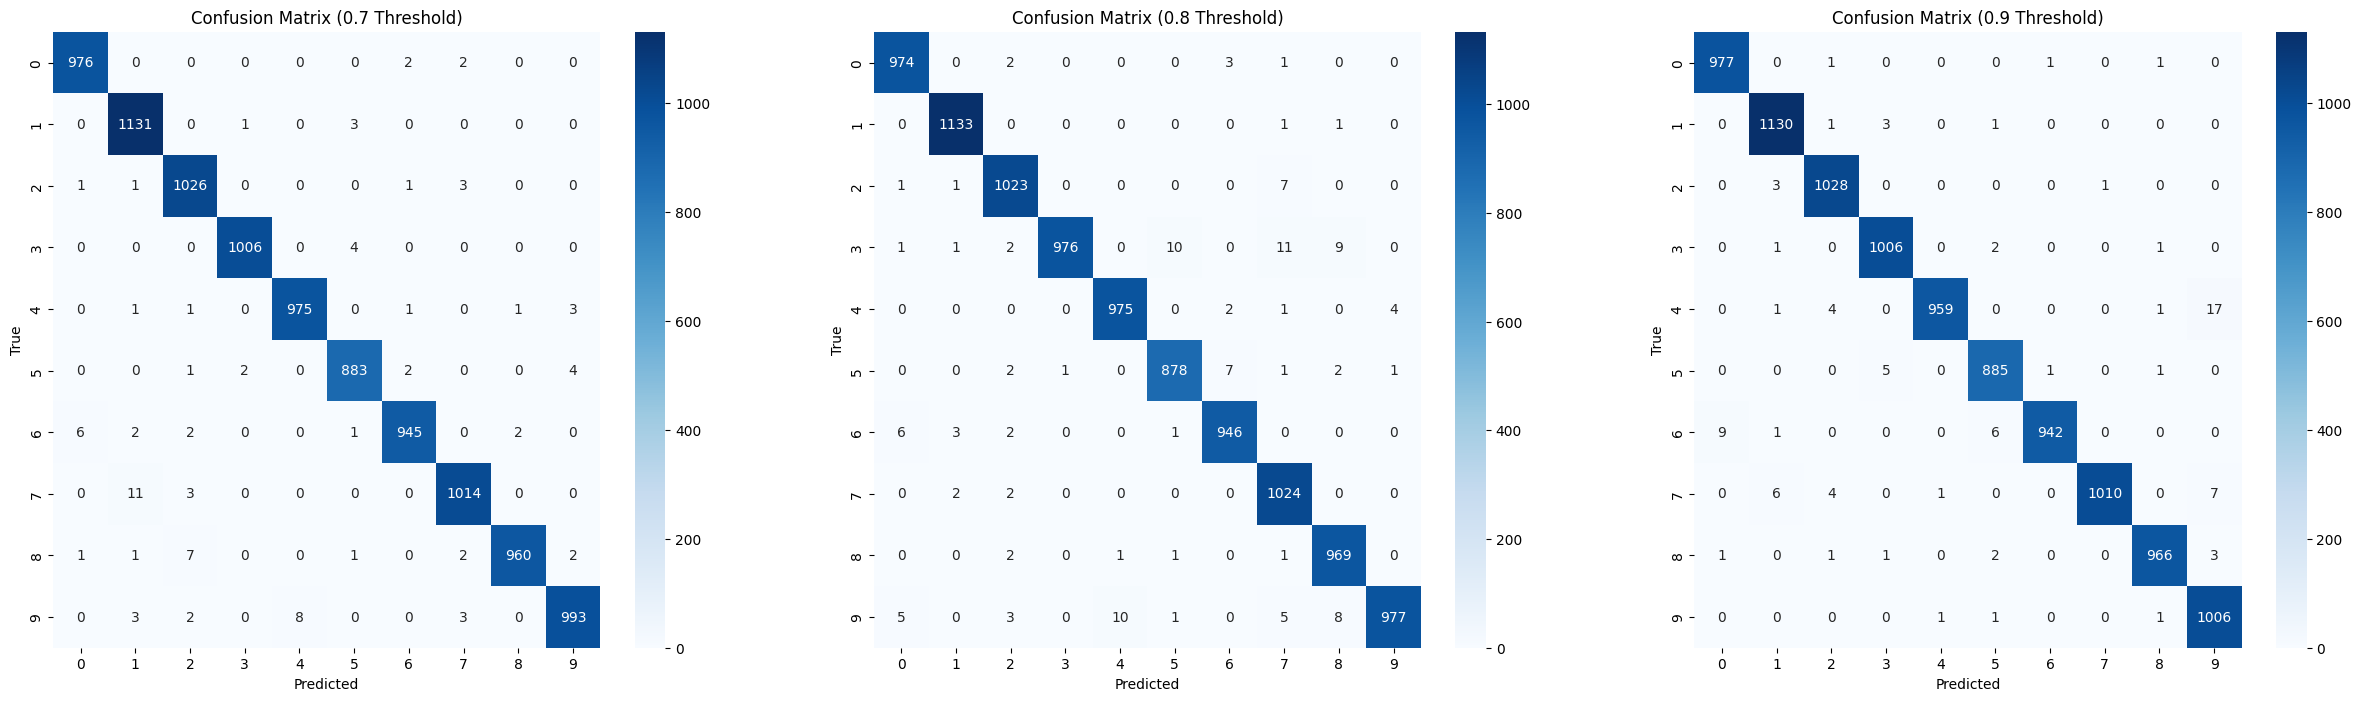

Classification Report (0.7 Threshold):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Classification Report (0.8 Threshold):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135

In [45]:
print(f"Accuracy of model trained with 20% labeled data and pseudo-labeling:")
print(f"0.7 Confidence Threshold: {accuracy_07}")
print(f"0.8 Confidence Threshold: {accuracy_08}")
print(f"0.9 Confidence Threshold: {accuracy_09}")

plt.figure(figsize=(30, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        sns.heatmap(conf_matrix_07, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.7 Threshold)')
    elif i == 1:
        sns.heatmap(conf_matrix_08, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.8 Threshold)')
    else:
        sns.heatmap(conf_matrix_09, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.9 Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.show()

print("Classification Report (0.7 Threshold):")
print(class_report_07)
print("\nClassification Report (0.8 Threshold):")
print(class_report_08)
print("\nClassification Report (0.9 Threshold):")
print(class_report_09)

Training a model on 30% labeled and 70% unlabeled data

In [46]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for _, subset_idx in strat_split.split(mnist_X, mnist_y):
    labeled_X = mnist_X[subset_idx]
    y = mnist_y[subset_idx]
    unlabeled_X = mnist_X[_]

In [47]:
strat_split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test, train in strat_split1.split(labeled_X, y):
    X_train = labeled_X[train]
    y_train = y[train]
    X_val = labeled_X[test]
    y_val = y[test]

In [48]:
labeled_train_dataset = MNISTDataset(labeled_X, y)
train_loader = DataLoader(labeled_train_dataset, batch_size=64, shuffle=True)

val_dataset = MNISTDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

unlabeled_dataset = MNISTDataset(unlabeled_X, np.zeros(len(unlabeled_X)))
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

In [49]:
model3 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

model3.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [50]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list_10 = []
accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    loss_list_10.append(avg_train_loss)


    model3.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   
model3.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.1256, Val Loss: 0.4966, Val Accuracy: 0.8705
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0427, Val Loss: 0.0386, Val Accuracy: 0.9878
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0291, Val Loss: 0.0784, Val Accuracy: 0.9793
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0203, Val Loss: 0.1537, Val Accuracy: 0.9608
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0260, Val Loss: 0.0258, Val Accuracy: 0.9925
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0187, Val Loss: 0.0392, Val Accuracy: 0.9889
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0245, Val Loss: 0.0316, Val Accuracy: 0.9911
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0133, Val Loss: 0.0279, Val Accuracy: 0.9924
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0134, Val Loss: 0.0619, Val Accuracy: 0.9834
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0099, Val Loss: 0.0875, Val Accuracy: 0.9764
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0140, Val Loss: 0.0491, Val Accuracy: 0.9880
Epoch 12/1000
Early stopping at epoch 12


<All keys matched successfully>

In [51]:
pseudo_indices_07 = []
pseudo_labels_07 = []

start_idx = 0

with torch.no_grad():
    model3.load_state_dict(best_model_weights)
    model3.eval()
    model3.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model3(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_07.append(batch_indices[mask_07.cpu()])
        pseudo_labels_07.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_07 = torch.cat(pseudo_indices_07)
pseudo_labels_07 = torch.cat(pseudo_labels_07)


In [52]:
pseudo_indices_08 = []
pseudo_labels_08 = []

start_idx = 0

with torch.no_grad():
    model3.load_state_dict(best_model_weights)
    model3.eval()
    model3.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model3(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.8

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_08.append(batch_indices[mask_07.cpu()])
        pseudo_labels_08.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_08 = torch.cat(pseudo_indices_08)
pseudo_labels_08 = torch.cat(pseudo_labels_08)


In [53]:
pseudo_indices_09 = []
pseudo_labels_09 = []

start_idx = 0

with torch.no_grad():
    model3.load_state_dict(best_model_weights)
    model3.eval()
    model3.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model3(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.9

        batch_indices = torch.arange(start_idx, start_idx + images.size(0))

        pseudo_indices_09.append(batch_indices[mask_07.cpu()])
        pseudo_labels_09.append(preds[mask_07].cpu())

        start_idx += images.size(0)

pseudo_indices_09 = torch.cat(pseudo_indices_09)
pseudo_labels_09 = torch.cat(pseudo_labels_09)


In [54]:
class PseudoDataset(Dataset):
    def __init__(self, base_dataset, indices, pseudo_labels):
        self.base_dataset = base_dataset
        self.indices = indices
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img, _ = self.base_dataset[self.indices[idx]]
        label = self.pseudo_labels[idx]
        return img, label
    
pseudo_dataset_07 = PseudoDataset(unlabeled_dataset, pseudo_indices_07, pseudo_labels_07)
combined_dataset_07 = ConcatDataset([labeled_train_dataset, pseudo_dataset_07])
combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

pseudo_dataset_08 = PseudoDataset(unlabeled_dataset, pseudo_indices_08, pseudo_labels_08)
combined_dataset_08 = ConcatDataset([labeled_train_dataset, pseudo_dataset_08])
combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

pseudo_dataset_09 = PseudoDataset(unlabeled_dataset, pseudo_indices_09, pseudo_labels_09)

combined_dataset_09 = ConcatDataset([labeled_train_dataset, pseudo_dataset_09])
combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [55]:
model3_07 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3_07.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model3_07.to(device)
loss_fn_07 = torch.nn.CrossEntropyLoss()
optimizer_07 = torch.optim.Adam(model3_07.parameters(), lr=0.001)

model3_08 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3_08.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model3_08.to(device)
loss_fn_08 = torch.nn.CrossEntropyLoss()
optimizer_08 = torch.optim.Adam(model3_08.parameters(), lr=0.001)

model3_09 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3_09.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model3_09.to(device)
loss_fn_09 = torch.nn.CrossEntropyLoss()
optimizer_09 = torch.optim.Adam(model3_09.parameters(), lr=0.001)


In [56]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3_07.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_07:
        optimizer_07.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3_07(X_batch)
        loss = loss_fn_07(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_07.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model3_07.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3_07(X_batch)
            test_loss = loss_fn_07(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3_07.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model3_07.load_state_dict(best_model_weights)


Epoch 1/1000
Epoch 1/1000, Train Loss: 0.2141, Val Loss: 0.1156, Val Accuracy: 0.9673
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.1011, Val Loss: 0.0478, Val Accuracy: 0.9861
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0779, Val Loss: 0.0535, Val Accuracy: 0.9874
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0732, Val Loss: 0.0303, Val Accuracy: 0.9909
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0689, Val Loss: 0.0257, Val Accuracy: 0.9914
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0578, Val Loss: 0.0399, Val Accuracy: 0.9882
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0619, Val Loss: 0.0328, Val Accuracy: 0.9896
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0484, Val Loss: 0.0290, Val Accuracy: 0.9918
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0468, Val Loss: 0.0218, Val Accuracy: 0.9946
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0394, Val Loss: 0.0898, Val Accuracy: 0.9766
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0497, Val Loss: 0.0518, Val Accuracy: 0.9889
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0326, V

<All keys matched successfully>

In [57]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3_08.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_08:
        optimizer_08.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3_08(X_batch)
        loss = loss_fn_08(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_08.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model3_08.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3_08(X_batch)
            test_loss = loss_fn_08(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3_08.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model3_08.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.2089, Val Loss: 0.0633, Val Accuracy: 0.9819
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0905, Val Loss: 0.0500, Val Accuracy: 0.9847
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0724, Val Loss: 0.0395, Val Accuracy: 0.9881
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0707, Val Loss: 0.0340, Val Accuracy: 0.9901
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0577, Val Loss: 0.0656, Val Accuracy: 0.9815
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0511, Val Loss: 0.0697, Val Accuracy: 0.9804
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0467, Val Loss: 0.0471, Val Accuracy: 0.9895
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0514, Val Loss: 0.0253, Val Accuracy: 0.9930
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0448, Val Loss: 0.0402, Val Accuracy: 0.9917
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0321, Val Loss: 0.0597, Val Accuracy: 0.9858
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0395, Val Loss: 0.0325, Val Accuracy: 0.9930
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0380, V

<All keys matched successfully>

In [58]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3_09.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_09:
        optimizer_09.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3_09(X_batch)
        loss = loss_fn_09(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_09.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model3_09.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3_09(X_batch)
            test_loss = loss_fn_09(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3_09.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model3_09.load_state_dict(best_model_weights)

Epoch 1/1000
Epoch 1/1000, Train Loss: 0.1898, Val Loss: 0.0374, Val Accuracy: 0.9893
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0761, Val Loss: 0.0457, Val Accuracy: 0.9869
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0666, Val Loss: 0.0525, Val Accuracy: 0.9849
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0594, Val Loss: 0.0322, Val Accuracy: 0.9904
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0532, Val Loss: 0.0288, Val Accuracy: 0.9911
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0492, Val Loss: 0.0806, Val Accuracy: 0.9778
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0430, Val Loss: 0.0239, Val Accuracy: 0.9937
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0370, Val Loss: 0.0406, Val Accuracy: 0.9898
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0358, Val Loss: 0.0312, Val Accuracy: 0.9932
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0405, Val Loss: 0.0560, Val Accuracy: 0.9853
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0340, Val Loss: 0.0397, Val Accuracy: 0.9920
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0299, V

<All keys matched successfully>

In [59]:
all_preds_07 = []
all_preds_08 = []
all_preds_09 = []

with torch.no_grad():
    model3_07.eval()
    model3_07.to(device)
    model3_08.eval()
    model3_08.to(device)
    model3_09.eval()
    model3_09.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs_07 = model3_07(X_batch)
        outputs_08 = model3_08(X_batch)
        outputs_09 = model3_09(X_batch)

        preds_07 = torch.argmax(outputs_07, dim=1)
        preds_08 = torch.argmax(outputs_08, dim=1)
        preds_09 = torch.argmax(outputs_09, dim=1)

        all_preds_07.append(preds_07.cpu())
        all_preds_08.append(preds_08.cpu())
        all_preds_09.append(preds_09.cpu())

all_preds_07 = torch.cat(all_preds_07)
all_preds_08 = torch.cat(all_preds_08)
all_preds_09 = torch.cat(all_preds_09)


accuracy_07 = accuracy_score(mnist_test_y, all_preds_07)
conf_matrix_07 = confusion_matrix(mnist_test_y, all_preds_07)
class_report_07 = classification_report(mnist_test_y, all_preds_07)

accuracy_08 = accuracy_score(mnist_test_y, all_preds_08)
conf_matrix_08 = confusion_matrix(mnist_test_y, all_preds_08)
class_report_08 = classification_report(mnist_test_y, all_preds_08)
accuracy_09 = accuracy_score(mnist_test_y, all_preds_09)
conf_matrix_09 = confusion_matrix(mnist_test_y, all_preds_09)
class_report_09 = classification_report(mnist_test_y, all_preds_09)

Accuracy of model trained with 30% labeled data and pseudo-labeling:
0.7 Confidence Threshold: 0.9946
0.8 Confidence Threshold: 0.993
0.9 Confidence Threshold: 0.9937


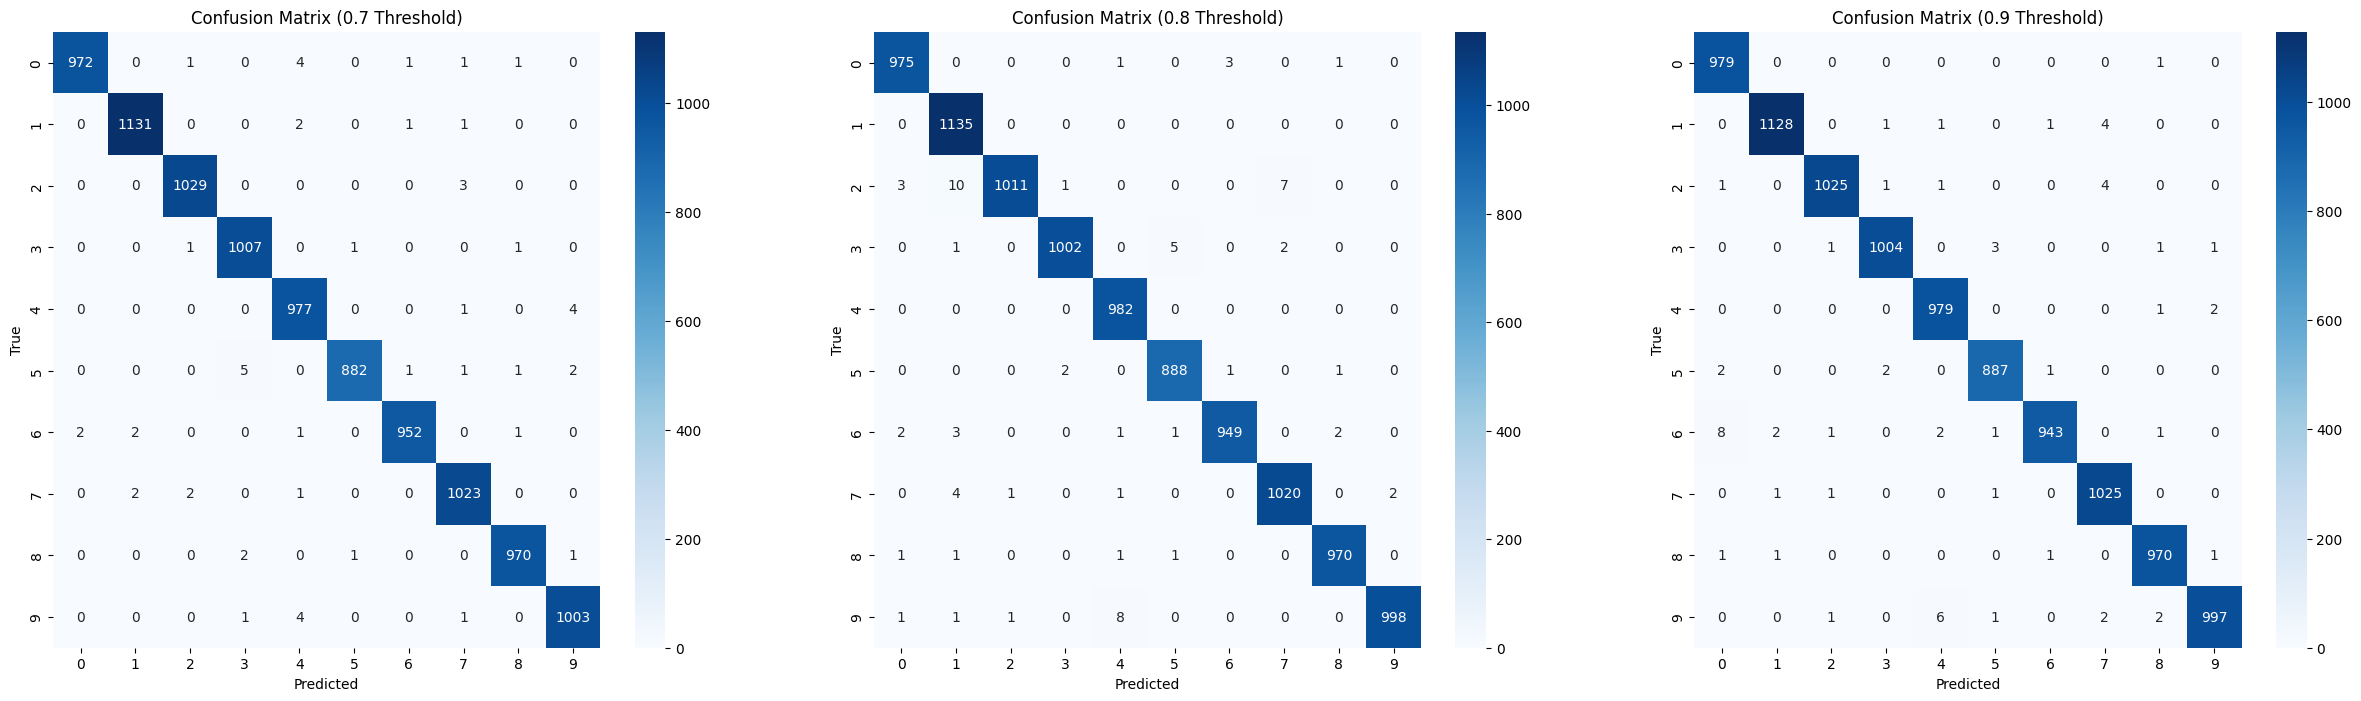

Classification Report (0.7 Threshold):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Classification Report (0.8 Threshold):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      1.00      0.99      1135

In [60]:
print(f"Accuracy of model trained with 30% labeled data and pseudo-labeling:")
print(f"0.7 Confidence Threshold: {accuracy_07}")
print(f"0.8 Confidence Threshold: {accuracy_08}")
print(f"0.9 Confidence Threshold: {accuracy_09}")

plt.figure(figsize=(30, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        sns.heatmap(conf_matrix_07, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.7 Threshold)')
    elif i == 1:
        sns.heatmap(conf_matrix_08, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.8 Threshold)')
    else:
        sns.heatmap(conf_matrix_09, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.9 Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.show()

print("Classification Report (0.7 Threshold):")
print(class_report_07)
print("\nClassification Report (0.8 Threshold):")
print(class_report_08)
print("\nClassification Report (0.9 Threshold):")
print(class_report_09)